In [71]:
import matplotlib

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, MetaData, Table, func, inspect, extract

In [8]:
#connect to database using sqllite create_engine function
engine = create_engine("sqlite:///hawaii.sqlite")

In [9]:
# reflect an existing database into a  python model 
Base = automap_base()
# reflect the tables from database into a python model
Base.prepare(engine, reflect=True)

In [10]:
# inspect tables and columns
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# print list of column names for Measurements
columns_M = inspector.get_columns('Measurement')

for column in columns_M:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# print list of column names for Stations
columns_S = inspector.get_columns('Station')

for column in columns_S:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Save references to each table
Mea = Base.classes.measurement
Sta = Base.classes.station


In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [17]:
# Check the data
for instance in session.query(Mea.prcp).limit(10).all():
    print(instance)

(0.08,)
(0.0,)
(0.0,)
(0.0,)
(None,)
(0.06,)
(0.0,)
(0.0,)
(0.0,)
(0.01,)


In [18]:
# Check the data
for instance in session.query(Sta.name).limit(10).all():
    print(instance)

('WAIKIKI 717.2, HI US',)
('KANEOHE 838.1, HI US',)
('KUALOA RANCH HEADQUARTERS 886.9, HI US',)
('PEARL CITY, HI US',)
('UPPER WAHIAWA 874.3, HI US',)
('WAIMANALO EXPERIMENTAL FARM, HI US',)
('WAIHEE 837.5, HI US',)
('HONOLULU OBSERVATORY 702.2, HI US',)
('MANOA LYON ARBO 785.2, HI US',)


# Establish Time stamps

In [19]:
# Retrieve the last 12 months of precipitation data. Select only the `date` and `prcp` values. ***
Latest_date = session.query(Mea.date).group_by(Mea.date).order_by(Mea.date.desc()).first()
Latest_date = pd.to_datetime(Latest_date)

In [20]:
# select your time stamp - the latest date on the database
Latest_date = Latest_date[0] 
Latest_date

Timestamp('2017-08-23 00:00:00')

In [21]:
#subtract one year from your latest date
year_date = Latest_date - timedelta(days=365)
year_date

Timestamp('2016-08-23 00:00:00')

# Exploratory Climate Analysis

In [23]:
# Perform a query to retrieve last 12 months precipitation data selecting only prcp and date
LTMprcp = session.query(Mea.date, Mea.prcp).filter(Mea.date >= '2016-08-23 00:00:00')\
.order_by(Mea.date.desc()).all()
LTMprcp[0:5]

[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0)]

In [24]:
# saving dates and prcp values from the query
date = [row[0] for row in LTMprcp]
prcp = [row[1] for row in LTMprcp]

In [25]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
#Sort the DataFrame values by `date`.
Prcp_df = pd.DataFrame(list(zip(date, prcp)), columns=['date', 'prcp']) 
Prcp_df.set_index('date', inplace=True)
Prcp_df.head()


,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


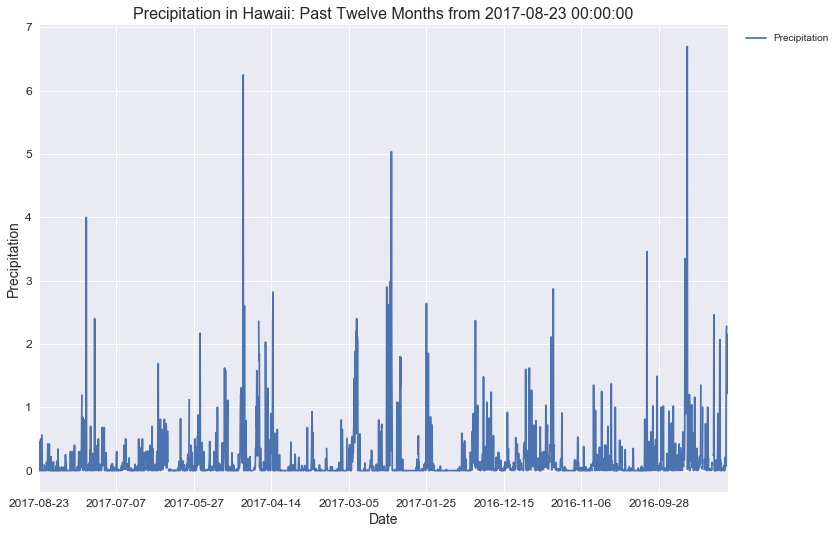

In [27]:
# *** Plot the results using the DataFrame `plot` method. ***
import seaborn as sns
sns.set_style('darkgrid')
Precip_plot = Prcp_df.plot(figsize=(11, 8), label="Precipitation")
plt.title('Precipitation in Hawaii: Past Twelve Months from ' + str(Latest_date), fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Precipitation']).set_bbox_to_anchor((1.16, 1))
plt.show()

In [28]:
Prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [29]:
# Design a query to calculate the total number of stations.
sta_tot = session.query(func.count(Sta.name)).all()
print('Number of stations: ' + str(sta_tot))

Number of stations: [(9,)]


In [30]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order.
act_sta = session.query(Mea.station, Sta.name, func.count(Mea.station))\
  .join(Sta, Mea.station == Sta.station)\
.group_by(Mea.station).order_by(func.count(Mea.station).desc()).all()
act_sta

# *** Printing findings ***       
print('Station ID, Station Name, Activity:')
print('**********************')

for instance in act_sta:
    print(instance)

sta_mos = act_sta[0][0]
name_most = act_sta[0][1]
print('**********************')
print('Most Active Station: ' + sta_mos + ' (' + name_most + ')')

Station ID, Station Name, Activity:
**********************
('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)
**********************
Most Active Station: USC00519281 (WAIHEE 837.5, HI US)


In [31]:
# Which station has the highest number of observations?
Top_tobs = session.query(Mea.station, Sta.name, func.count(Mea.tobs))\
  .join(Sta, Mea.station == Sta.station)\
.group_by(Sta.name).order_by(func.count(Mea.tobs).desc()).all()
Top_tobs[0]

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [32]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tdata = [Mea.date, Mea.tobs, Mea.station]

temp_data = session.query(*tdata).\
   filter(Mea.station=='USC00519397').\
   filter(Mea.date >= '2016-08-23 00:00:00').all()
temp_data[0:5]

[('2016-08-24', 79.0, 'USC00519397'),
 ('2016-08-25', 80.0, 'USC00519397'),
 ('2016-08-26', 79.0, 'USC00519397'),
 ('2016-08-27', 77.0, 'USC00519397'),
 ('2016-08-28', 78.0, 'USC00519397')]

In [33]:
# *** Load the query results into a Pandas DataFrame and set the index to the date column. ***
Date = [row[0] for row in temp_data]
Temps = [row[1] for row in temp_data]
temp_data_df = pd.DataFrame(list(zip(Date, Temps)), columns=['date', 'temp'])
temp_data_df.set_index('date', inplace=True)
temp_data_df.tail()

,temp
date,
2017-08-19,79.0
2017-08-20,81.0
2017-08-21,81.0
2017-08-22,82.0
2017-08-23,81.0


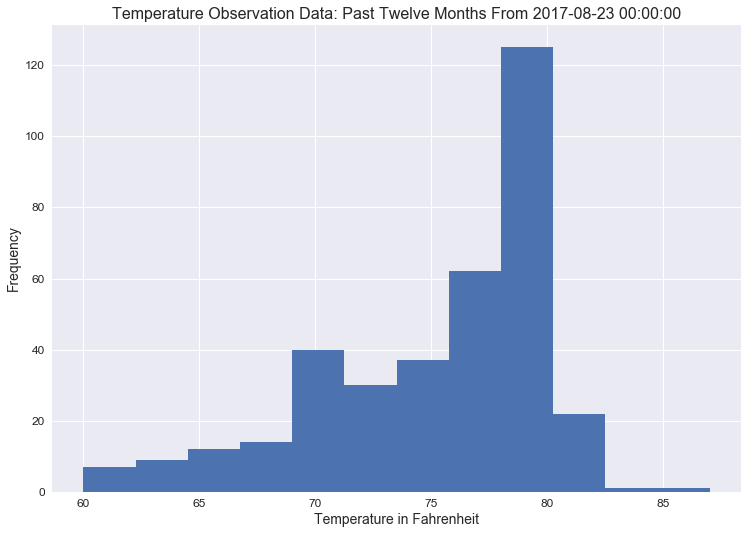

In [34]:
# *** Plot the results as a histogram with `bins=12`. ***
temp_data_df.hist(figsize=(11, 8), bins=12)
plt.title('Temperature Observation Data: Past Twelve Months From ' + str(Latest_date), fontsize=16)
plt.xlabel('Temperature in Fahrenheit', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Temperature Analysis

In [45]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    try:
        temp_range = session.query(Mea.date, func.min(Mea.tobs), \
                    func.avg(Mea.tobs), func.max(Mea.tobs))\
                    .filter(Mea.date.between(start_date, end_date))\
                    .group_by(Mea.date)\
                    .order_by(Mea.date)
        return(temp_range)
        
    except ValueError:
        print('There was a wrong parameter!')

In [46]:
#pick dates to test calc test function
Trip = calc_temps('2016-08-20', '2016-08-27')

for days in Trip:
    print(days)

('2016-08-20', 76.0, 79.66666666666667, 81.0)
('2016-08-21', 74.0, 77.0, 80.0)
('2016-08-22', 72.0, 77.28571428571429, 80.0)
('2016-08-23', 74.0, 78.28571428571429, 81.0)
('2016-08-24', 74.0, 77.57142857142857, 80.0)
('2016-08-25', 77.0, 79.42857142857143, 81.0)
('2016-08-26', 78.0, 80.5, 84.0)
('2016-08-27', 73.0, 76.83333333333333, 81.0)


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip_dic = {'date':[], 'min_temp':[], 'avg_temp':[], 'max_temp':[], 'range_temp':[]}
for day in Trip:
    Trip_dic['date'].append(day[0])
    Trip_dic['min_temp'].append(day[1])
    Trip_dic['avg_temp'].append(day[2])
    Trip_dic['max_temp'].append(day[3])
    Trip_dic['range_temp'].append(day[3] - day[1]) 
    
Trip_df = pd.DataFrame(Trip_dic)
Trip_df.set_index('date', inplace=True)
Trip_df.head()

,avg_temp,max_temp,min_temp,range_temp
date,,,,
2016-08-20,79.666667,81.0,76.0,5.0
2016-08-21,77.000000,80.0,74.0,6.0
2016-08-22,77.285714,80.0,72.0,8.0
2016-08-23,78.285714,81.0,74.0,7.0
2016-08-24,77.571429,80.0,74.0,6.0


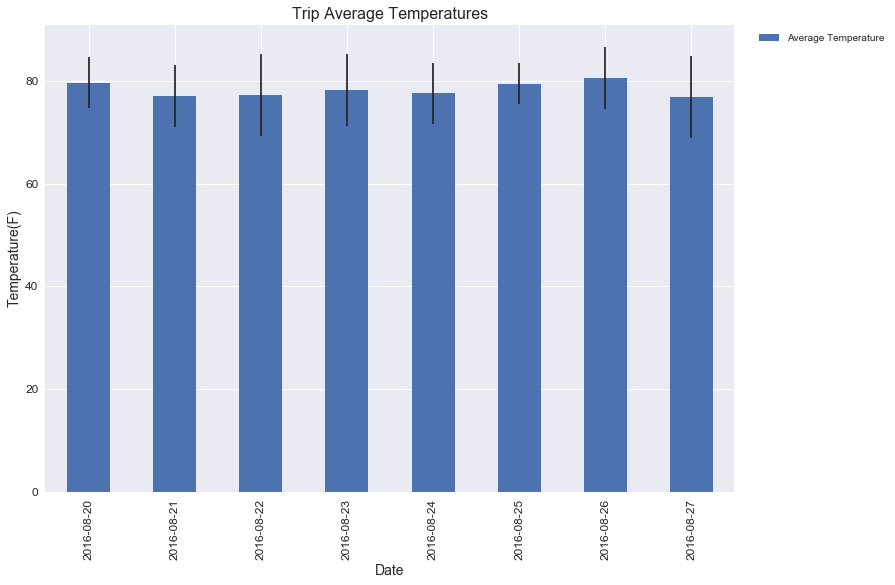

In [48]:
# Plot the results from your previous query as a bar chart.  # Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Trip_df.plot(x=Trip_df.index, y='avg_temp', kind='bar', yerr='range_temp', figsize=(11, 8), fontsize=16)
plt.title("Trip Average Temperatures", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature(F)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Average Temperature']).set_bbox_to_anchor((1.23, 1))
plt.show()

In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2016, 8, 14) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 8, 18) - dt.timedelta(days=365)



In [50]:
calc_temps('2016-08-20', '2016-08-27')

In [54]:
tmin= calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
tmin

('2015-08-15', 73.0, 79.16666666666667, 83.0)

In [61]:
t_values= calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
t_values

('2015-08-15', 73.0, 79.16666666666667, 83.0)

In [60]:
tmin=t_values[1]
tmin

73.0

In [63]:
tmax=t_values[2]
tmax

79.16666666666667

In [64]:
tavg=t_values[3]
tavg

83.0

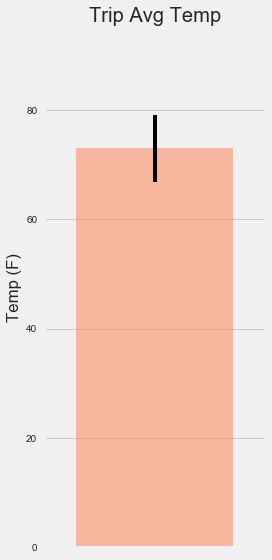

In [74]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmin, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.autofmt_xdate()
fig.tight_layout()
# fig.show()